In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
plt.style.use(mplhep.style.CMS)

In [31]:
output = util.load("outfiles/Run3Summer22EE/fulllumi/jer_ScoutingPFMonitor_Run2022F.coffea")[0]

In [68]:
def resolution(h, wmin=0.2, wmax=1.8, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = h.sum()

    # number of jets in each bin
    values = h.values()

    # bin centers
    centers = h.axes[0].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print(f"here {i} and {j}")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
#                     print(points[j][0], points[i][0], wy, wx)
                    width = wx
#     print(low, high)
    return low, high, 0.5 * (high - low)

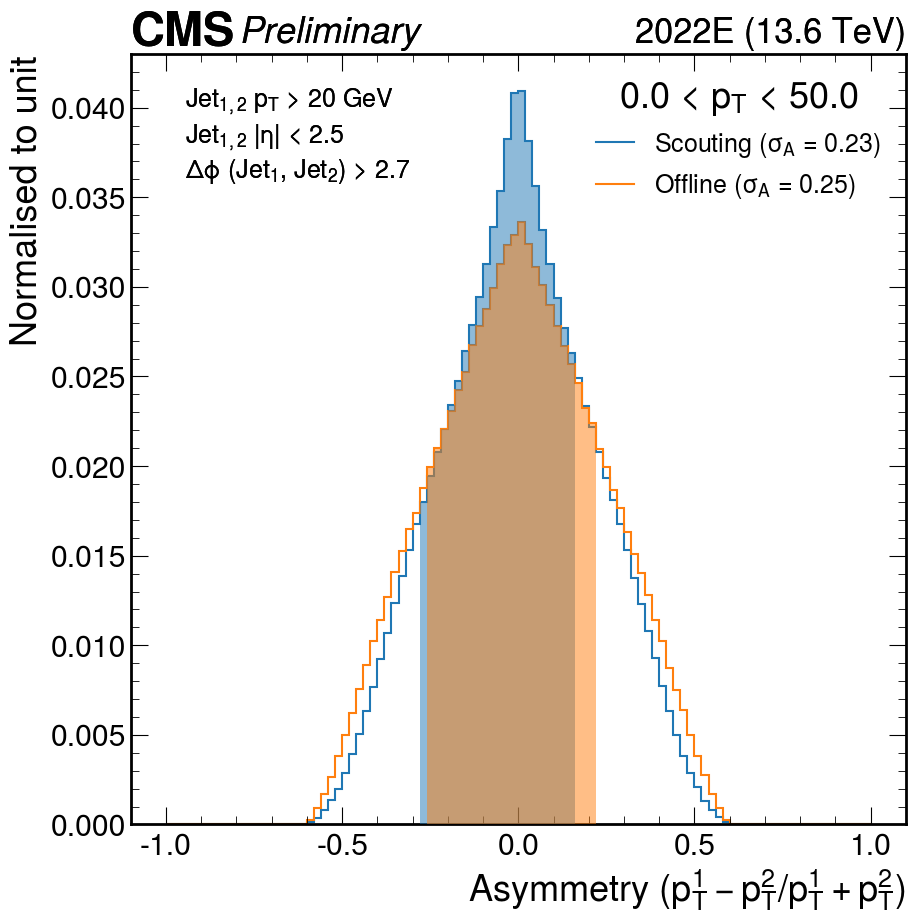

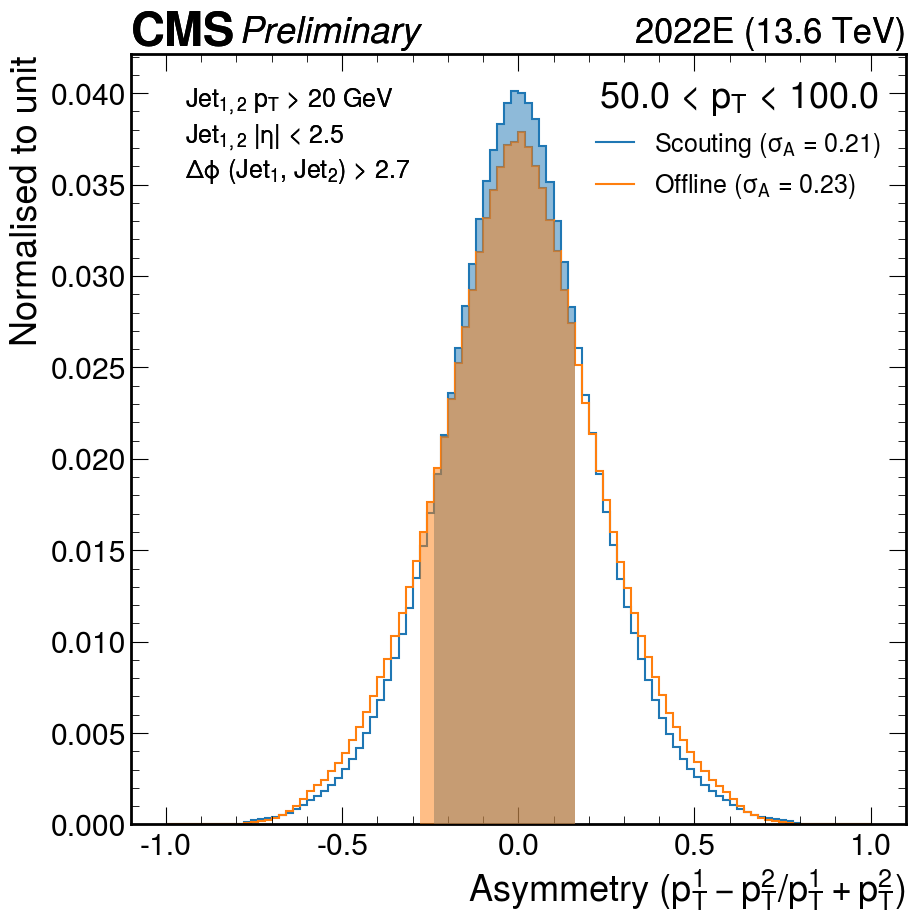

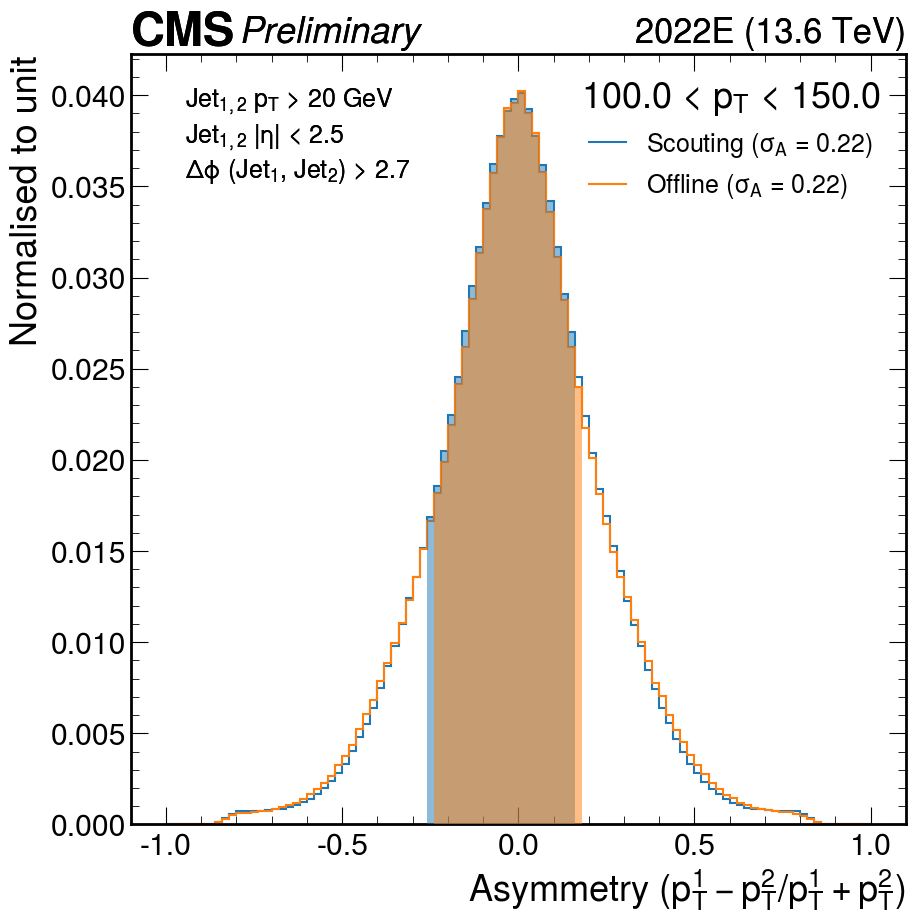

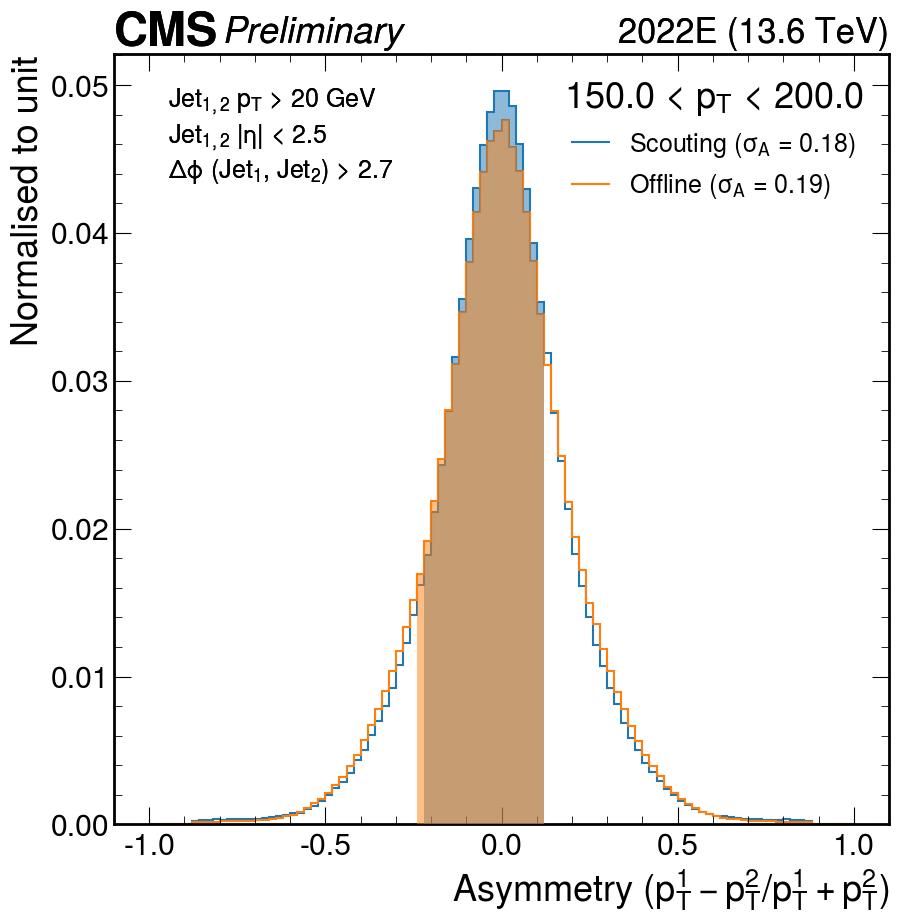

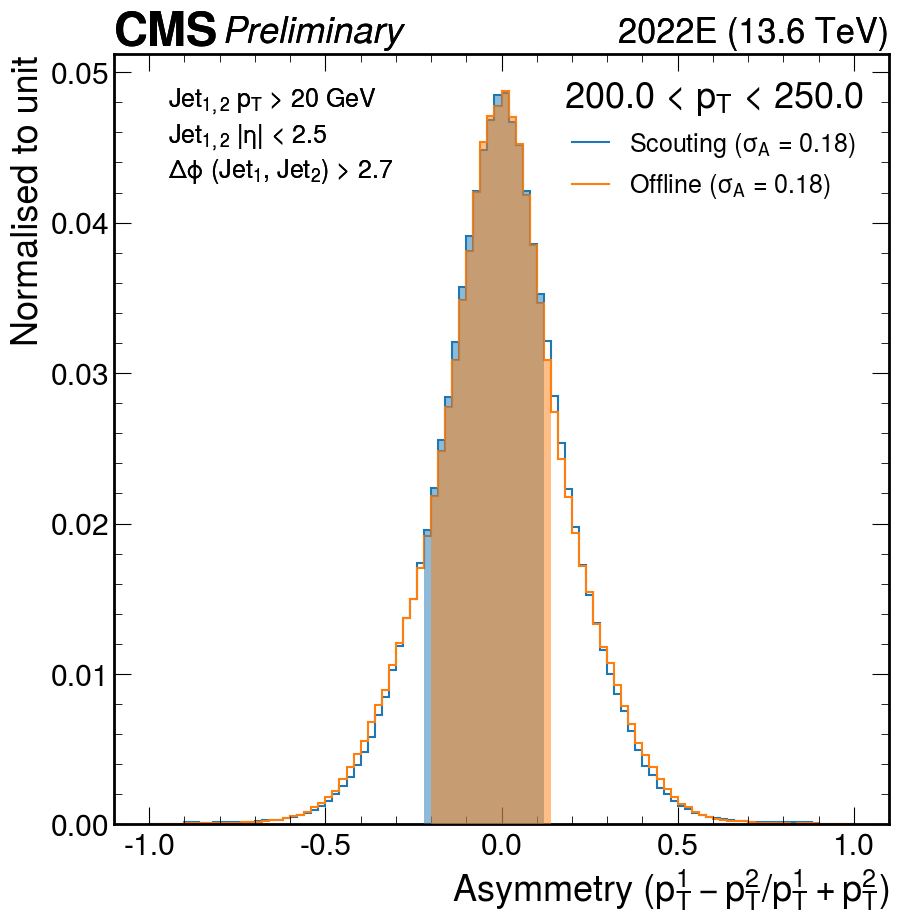

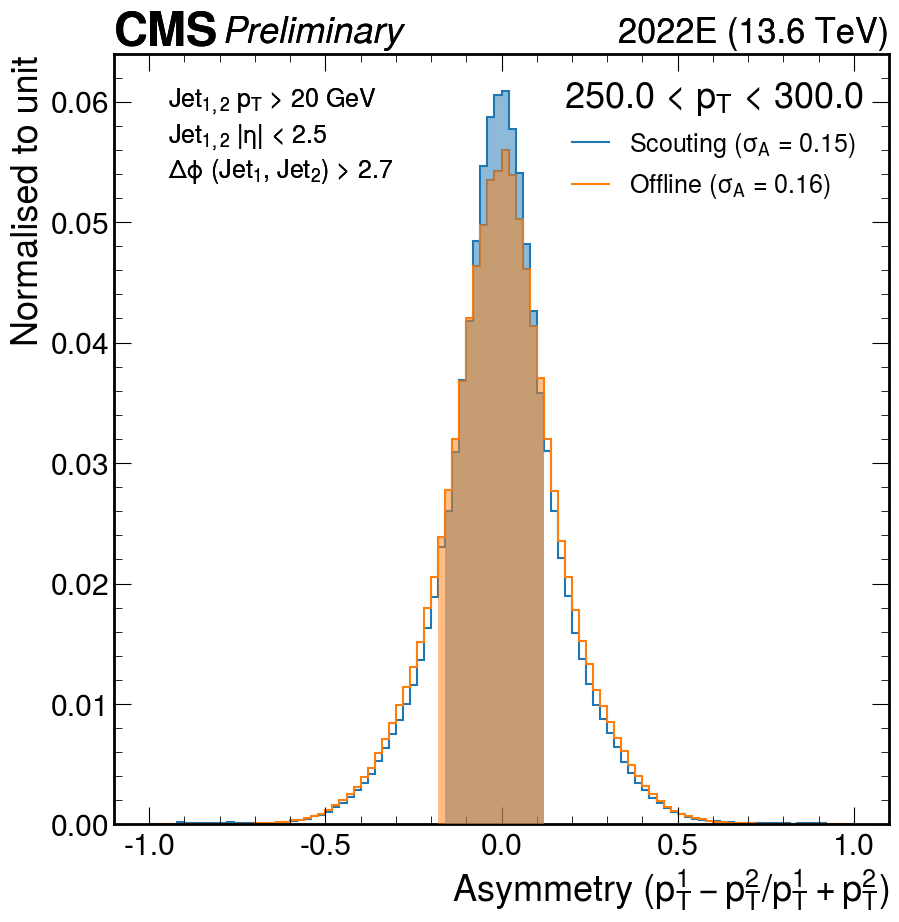

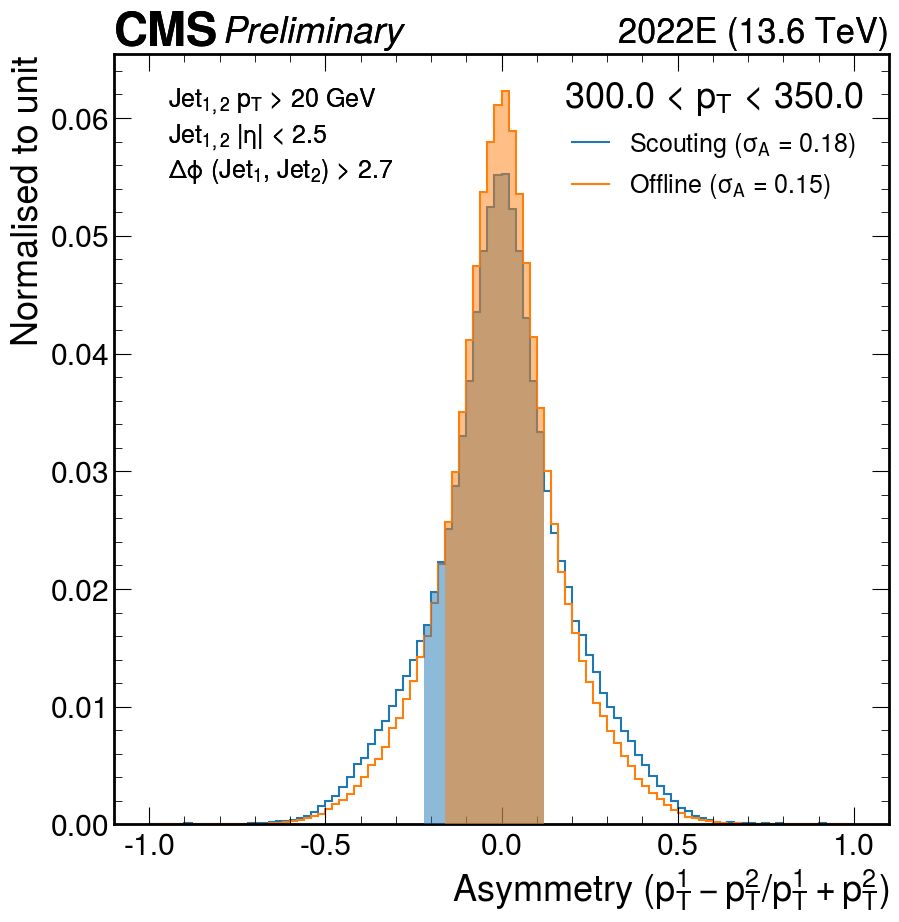

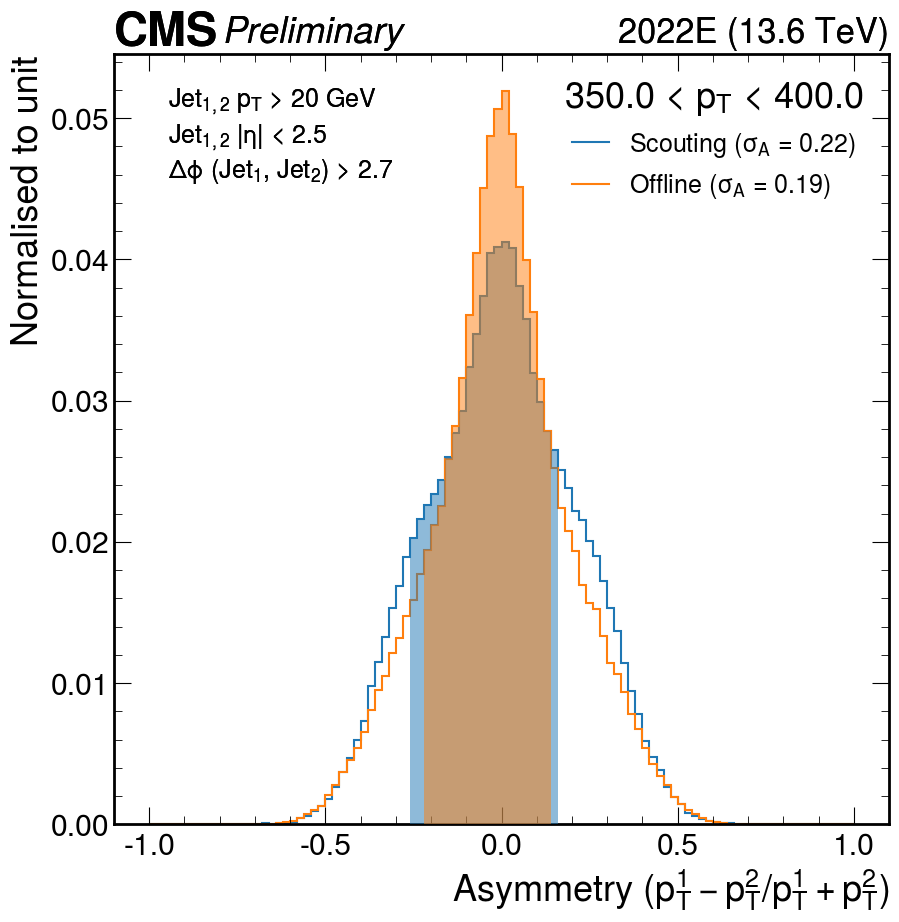

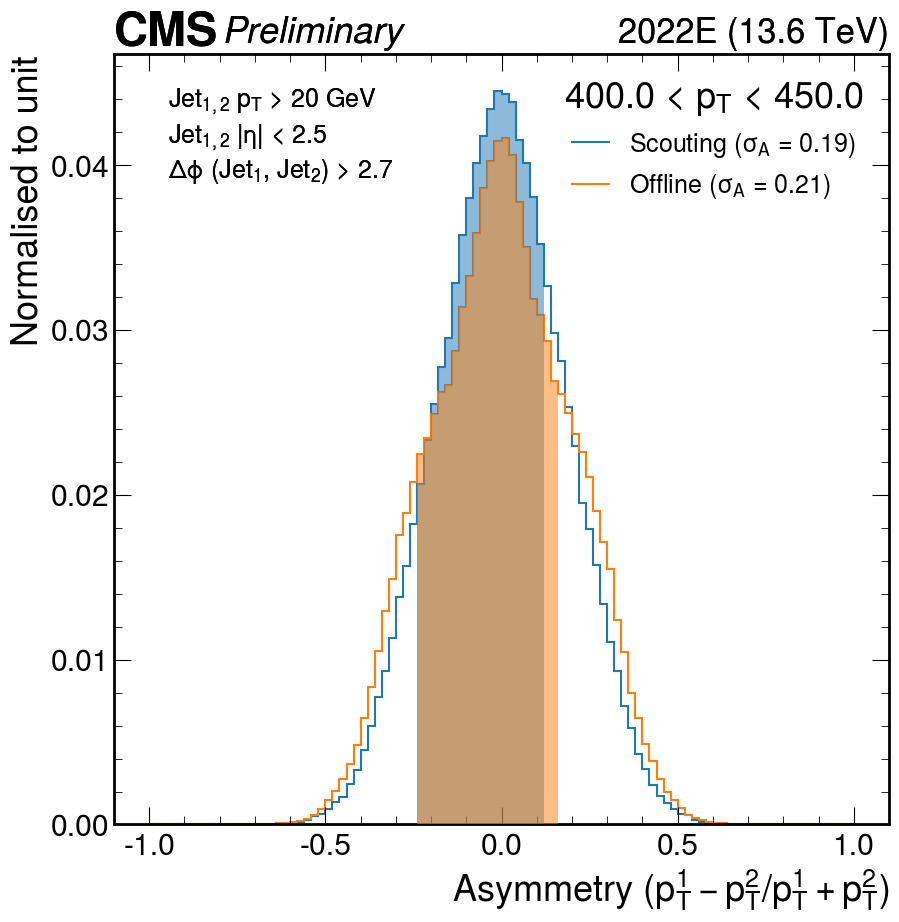

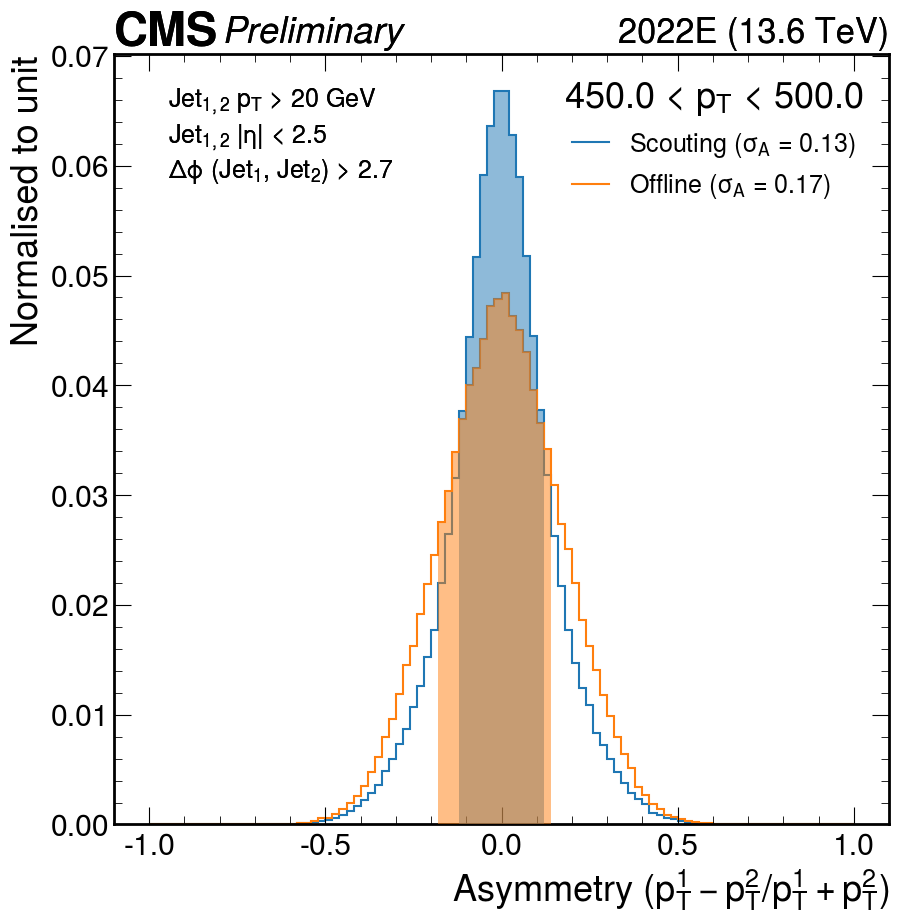

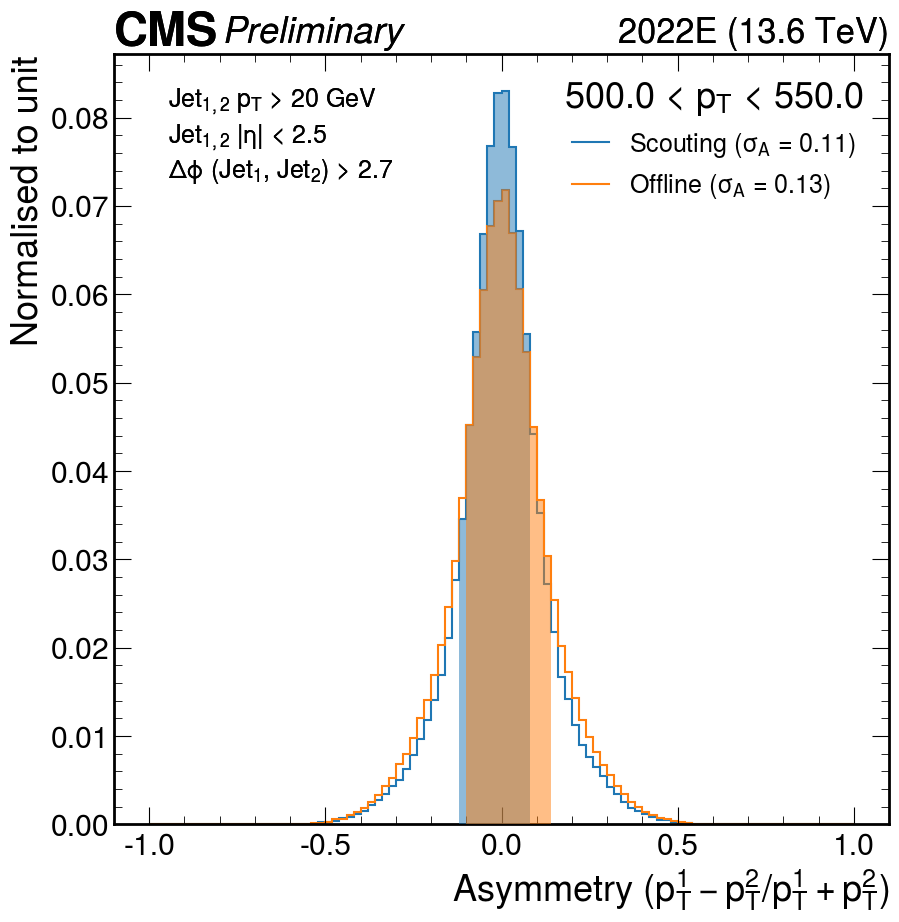

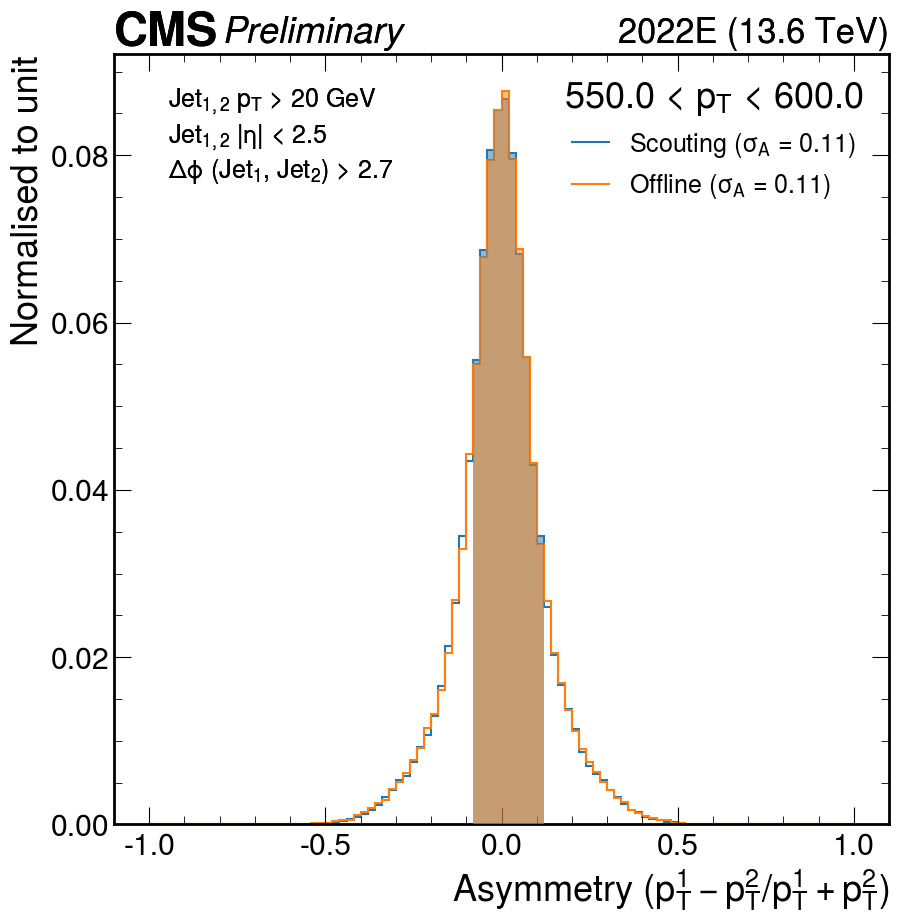

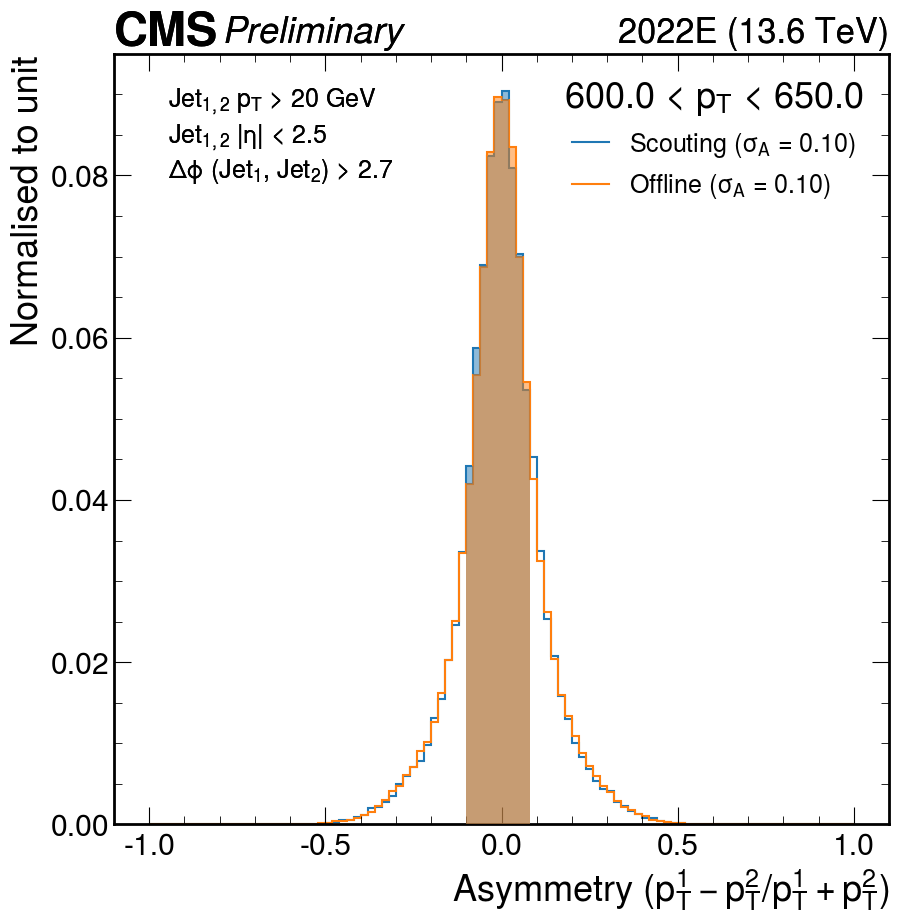

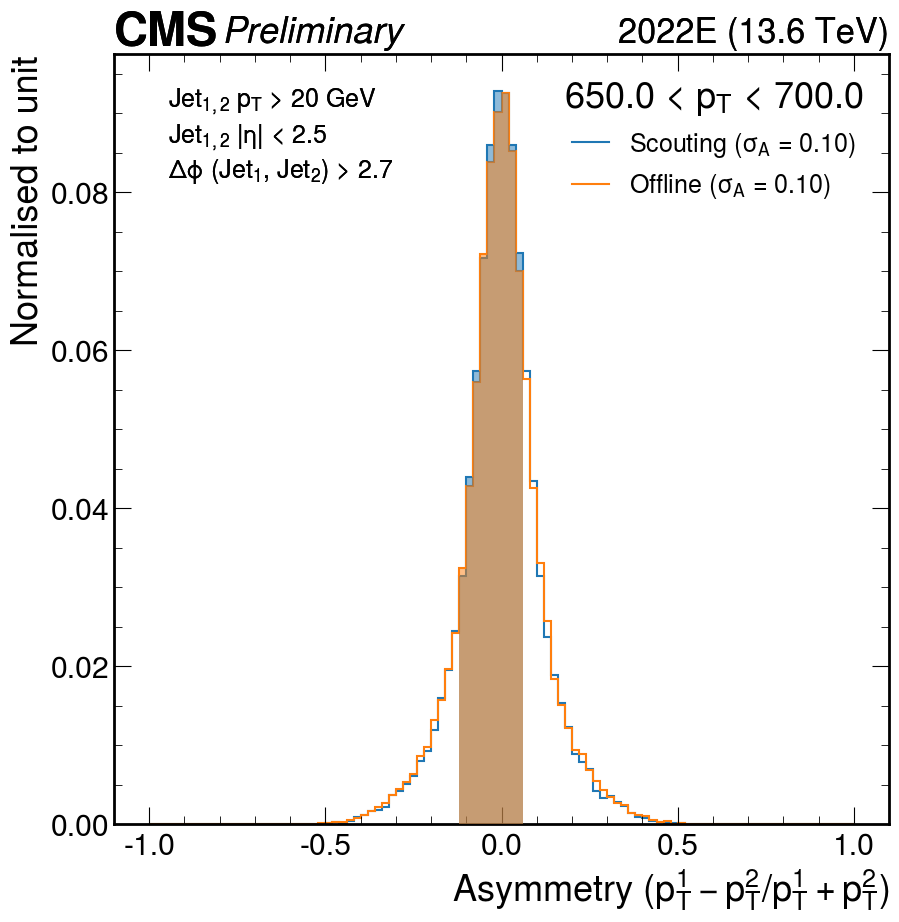

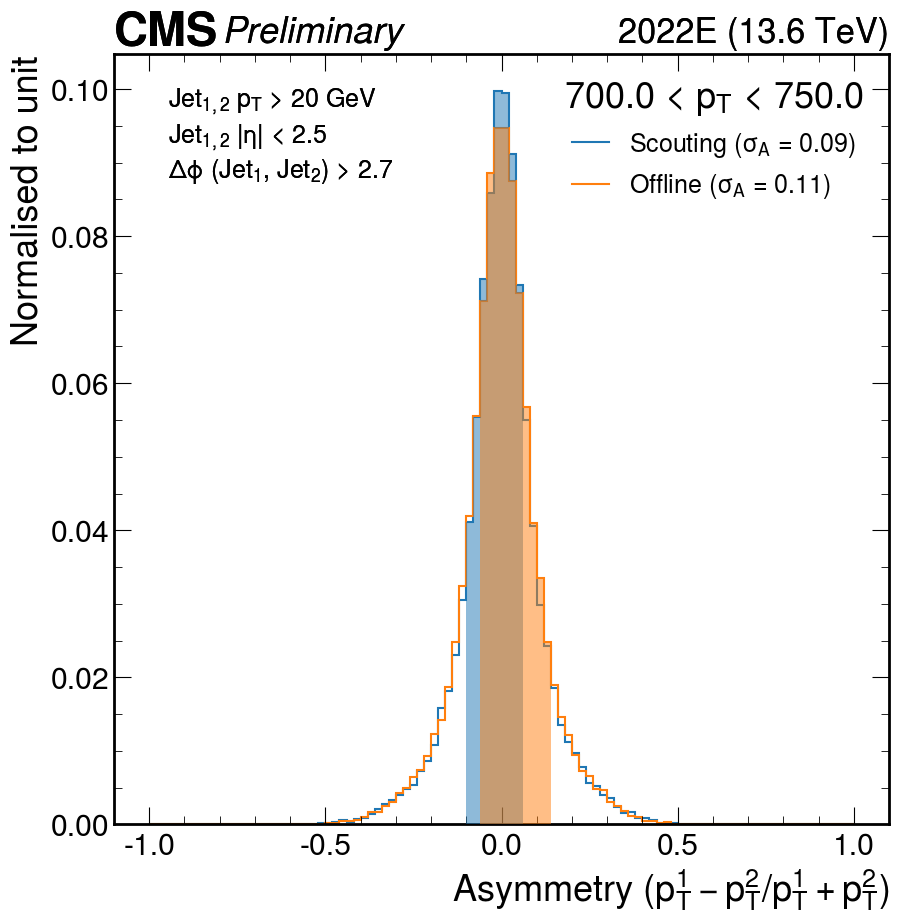

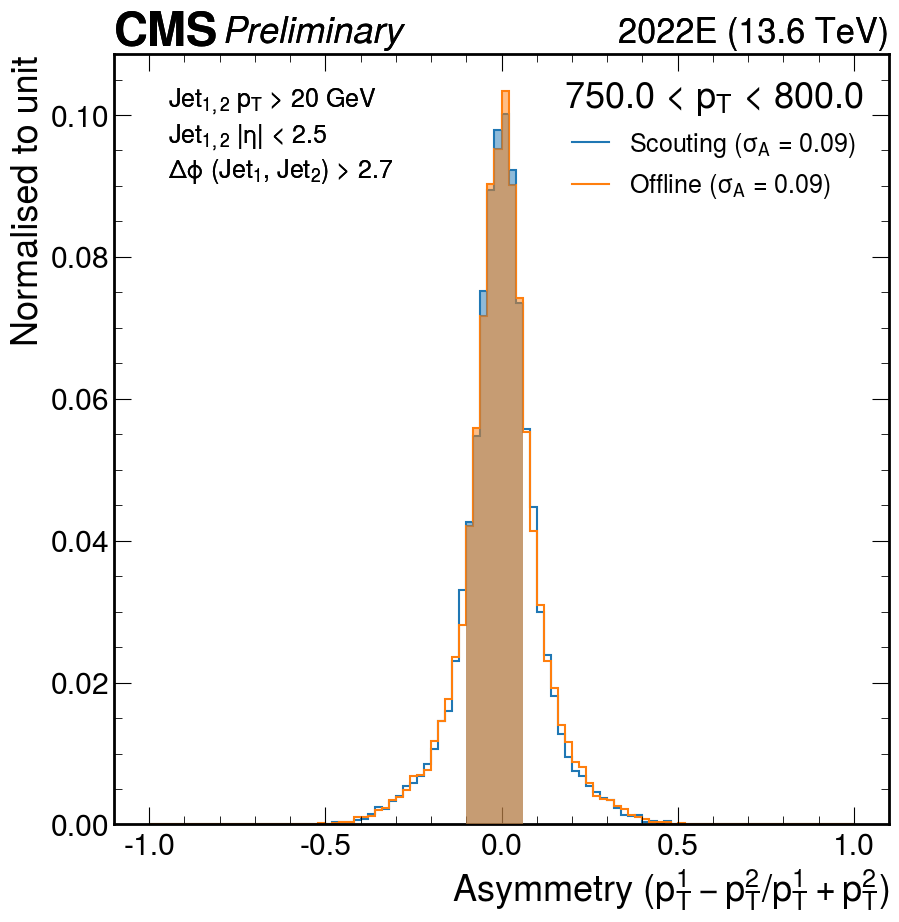

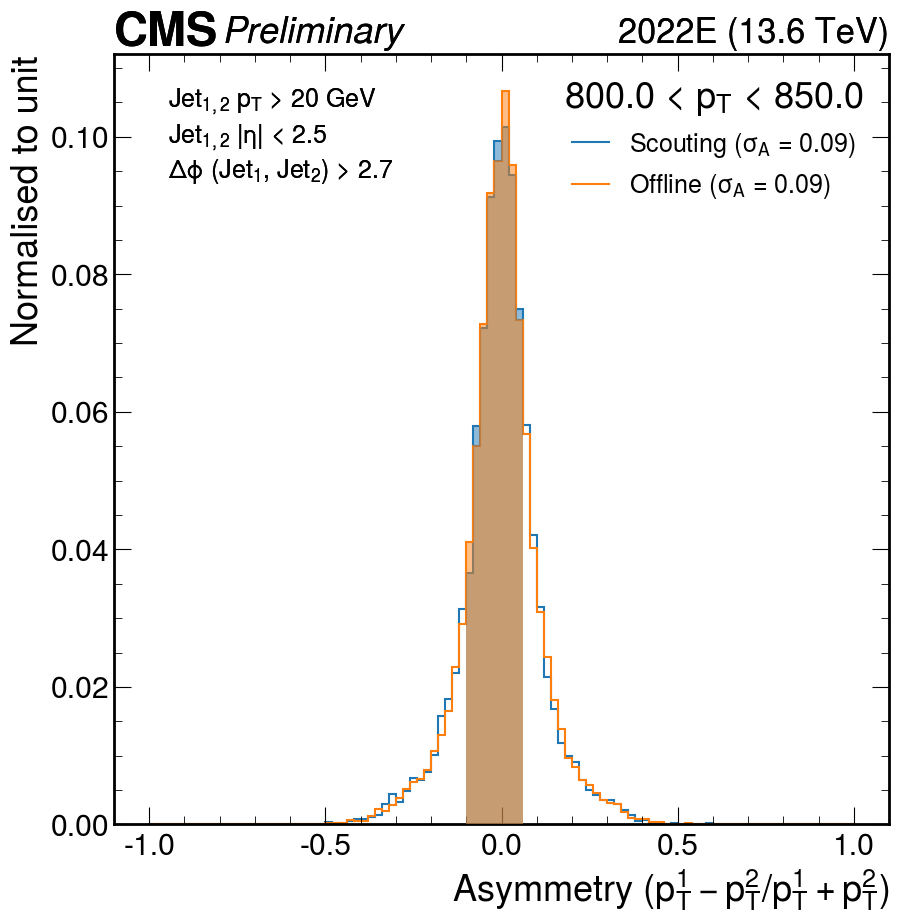

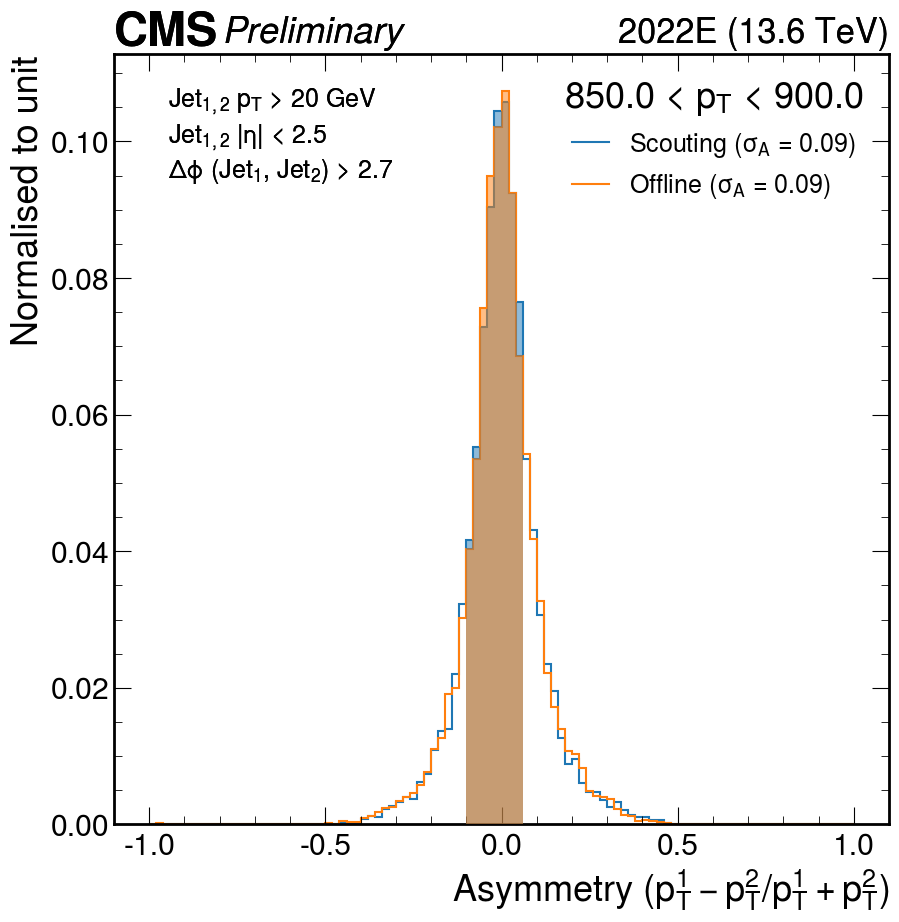

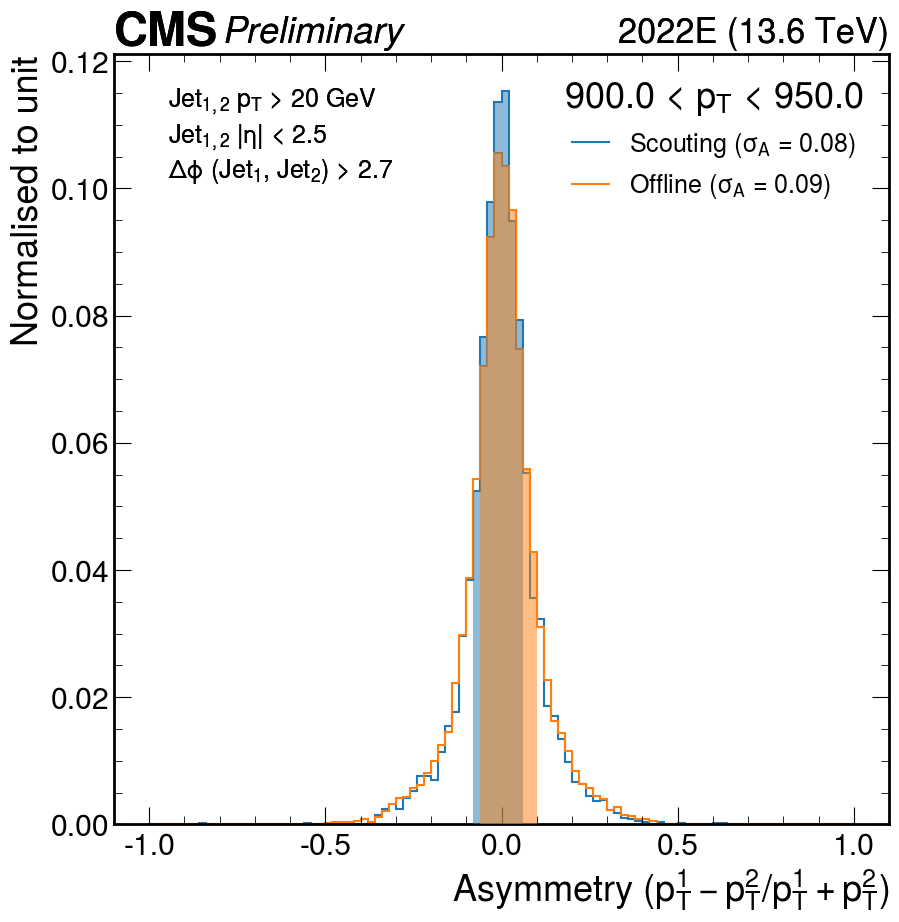

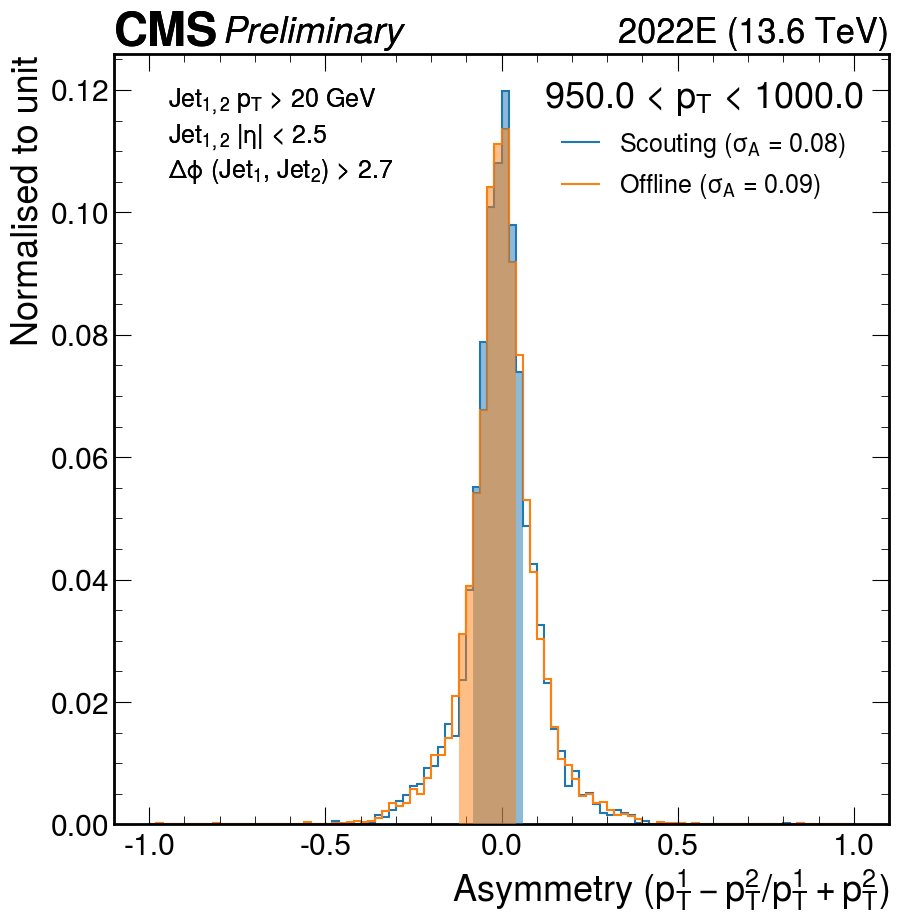

In [137]:
res_scouting = []
res_offline = []

for i, _ in enumerate(output["scouting"].project("pt_ave").axes[0].centers):
    fig, ax = plt.subplots()
    
    for rec in ["scouting","offline"]:
    
        h = output[rec].project("asymmetry", "pt_ave")[{"pt_ave" : i}]
        h *= 1 / h.sum()
        
        low, high, res = resolution(h)
        
        if rec == "scouting":
            res_scouting.append(res)
        else:
            res_offline.append(res)

        mplhep.histplot(h, label=rec.capitalize() + r" ($\sigma_A$" + f" = {res:.2f})")
        
        opts = {'step': 'post', 'linewidth': 0, 'zorder':100., 'alpha' : 0.5}
        edges = h.axes[0].edges
        ax.fill_between(edges, np.r_[h.values(), h.values()[-1]], where=np.logical_and(edges > low, edges < high), **opts)

        mplhep.cms.label(ax=ax, data=True, year="2022E", com=13.6, label="Preliminary")
        ax.text(0.07, 0.83, r"Jet$_{1, 2}$ p$_T$ > 20 GeV" + "\n" + r"Jet$_{1, 2}$ |$\eta$| < 2.5" + "\n" + r"$\Delta \phi$ (Jet$_1$, Jet$_2$) > 2.7",
                fontsize=18,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes
               )
        edges = output["scouting"].project("pt_ave").axes[0].edges
        ax.legend(loc="upper right", title=f"{edges[i]}" + r" < $p_T$ < " + f"{edges[i+1]}", fontsize=18)
        ax.set_ylabel("Normalised to unit")
        ax.set_xlabel(r"Asymmetry ($p_T^1 - p_T^2 / p_T^1 + p_T^2$)")

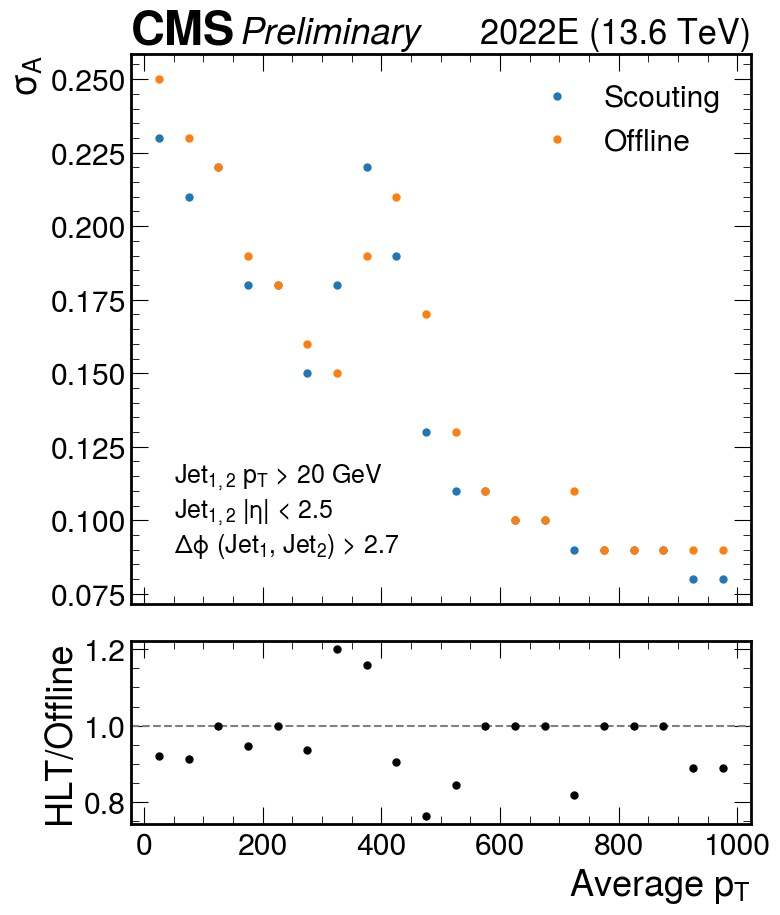

In [139]:
from coffea.hist import clopper_pearson_interval, poisson_interval

fig, (ax, rax) = plt.subplots(
            2, 1, figsize=(8, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
        )
fig.subplots_adjust(hspace=0.1)

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            #'color': 'k',
            'elinewidth': 1,
        }

ax.errorbar(
    output["scouting"].project("pt_ave").axes[0].centers,
    res_scouting,
    #xerr=centers[1]-centers[0],
    #yerr=rsumw_unc,
    label="Scouting",
    **data_err_opts,
)

ax.errorbar(
    output["offline"].project("pt_ave").axes[0].centers,
    res_offline,
    #xerr=centers[1]-centers[0],
    #yerr=rsumw_unc,
    label="Offline",
    **data_err_opts,
)

rax.errorbar(
    output["offline"].project("pt_ave").axes[0].centers,
    [s / o for s, o in zip(res_scouting, res_offline)],
    #xerr=centers[1]-centers[0],
    #yerr=rsumw_unc,
    **data_err_opts,
    color="black",
)

ax.legend(loc="best")
mplhep.cms.label(ax=ax, data=True, year="2022E", com=13.6, label="Preliminary")
ax.text(0.07, 0.08, r"Jet$_{1, 2}$ p$_T$ > 20 GeV" + "\n" + r"Jet$_{1, 2}$ |$\eta$| < 2.5" + "\n" + r"$\Delta \phi$ (Jet$_1$, Jet$_2$) > 2.7",
        fontsize=18,
        horizontalalignment='left',
        verticalalignment='bottom',
        transform=ax.transAxes
       )
ax.set_ylabel(r"$\sigma_A$")
ax.set_xlabel("")
rax.set_xlabel(r"Average $p_T$")
rax.set_ylabel("HLT/Offline")
rax.axhline(1, color='gray',ls='--')